# Quantum-Classical Convolutional Neural Networks (QCCNN) for detecting hand-written digits


## 1. Introduction to classical Convolutional Neural Networks

Convolutional Neural Networks (CNN) emerged from the study of the brain's visual cortex, and they have been used in image recognition since the 1980s. Thanks to the increase in computational power and their training with backpropagation, they have been able to achieve superhuman performance in complex visual tasks such as image search services, automatic video classification systems, and even self-driving cars [1]. In contrast to fully-connected neural networks (FCNN), where images have to be flattened to be processed and every neuron in the first layer was connected to all pixels in the image, in CNN each neuron is only connected to neurons in its receptive field, as shown in the figure below [1]:

<img src="figures_qccnn/cnn.png" alt="Convolutional Neural Network" width="500">

The fundamental building block of a CNN is the convolutional layer, which consists of applying a convolution between the image (or previous layer) with a kernel. The kernel is just a matrix which can have several filters (making it a rank 3 tensor), and the convolution consists of sliding this kernel through the image and multiplying element by element, adding the results and applying an activation function such as ReLU. The output is thus another image of reduced size, but usually with more channels. The other block of CNNs is the pooling layer, which takes square sections of the image (of a certain size) and either outputs the maximum (MaxPooling) or average (AveragePooling). In this way, the dimensionality of the image is reduced. Finally, after applying several convolutional and pooling layers, the image is flattened and a FCNN is applied to classify the image. This set up is shown in the figure below [2]

<img src="figures_qccnn/cnn2.png" alt="Convolutional Neural Network Architecture" width="600">

This architecture allows the network to concentrate on small low-level features in the first hidden layers, then assemble them into larger higher-level features in the next hidden layer, and so on [1], which is why this type of NN works so well for image recognition [1].

## 2. Quantum-Classical Convolutional Neural networks

There are many different types of architectures that combine CNNs with quantum circuits. Some of them use a single quantum circuit to process the whole image, mapping pixels to qubits through a feature map, and using variational parameters to simulate the weights. These are called QCNNs if the quantum circuits are translationally invariant. Some papers describing this type of Quantum CNNs are [3] and [4], but they have the inconvenient that they with the actual NISQ devices and simulators, which can process a small number of qubits, only very small images and toy datasets can be implemented. For instance, the MNIST dataset, which has images of 784 pixels, around 784 qubits are needed.

Thus, in this tutorial we focus on hybrid Quantum-Classical Convolutional Neural Network (QCCNN), termed as Quanvolutional Neural Network in [5] and [6]. The quanvolutional layer consists of, instead of multiplying small rectangles of the image with a kernel, applying small quantum circuits of 4 (2x2) or 9 (3x3) qubits, which first map the pixel values of the rectangle to quantum states through a feature map, and then apply an ansatz (which is random and fixed in the paper). In [5], $\langle Z \rangle$ is measured for each qubit, and each of the results is used as the corresponding pixel value of each of the channels of the next layer. After applying one or several of these quanvolutional layers, classic convolutional and pooling layers are applied, followed by a FCNN. This architecture is shown in the figure below [5].

<img src="figures_qccnn/quanv.png" alt="Quanvolutional Neural Network Architecture" width="600">

In this tutorial, we substitute the random circuit with a variational one. For training, the logic works as follows: first, we initialize the quantum variational parameters randomly and train the classical neural network with backpropagation and Adam; and then, with the trained classical model fixed

## 3. Implementation of Quanvolutional NN for the MNIST dataset

MNIST is a commonly used dataset for benchmarking that contains 28x28 grey scale images of hand-written digits, along with a label of the digit they represent. In the following, we implement the machine learning pipeline (dataset uploading, model definition, training, and assesing the network performance). In particular, you can define a custom feature map and ansatz, as well as the classical CNN architecture.




0. Import the necessary packages and the QC_CNN class

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from time import time
from qat.lang.AQASM import Program, H, RX, RY, RZ, CNOT
from qat.qpus import get_default_qpu, PyLinalg
from qat.core import Observable, Term
from qat.plugins import ObservableSplitter
#from qlmaas.qpus import LinAlg # Comment when using myQLM

from myQML import QCCNN, Angle_Encoding


1. Load the MNIST dataset, selecting the number of training and test images, and then normalize the image pixels to values between 0 and 1.

In [2]:
n_training_images = 300
n_test_images = 75

mnist_dataset = tf.keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist_dataset.load_data()

train_images = train_images[:n_training_images]
train_labels = train_labels[:n_training_images]
test_images = test_images[:n_test_images]
test_labels = test_labels[:n_test_images] 

train_images = train_images / 255
test_images = test_images / 255

# Add extra dimension for convolution channels
train_images = np.array(train_images[..., tf.newaxis])
test_images = np.array(test_images[..., tf.newaxis])

np.random.seed(1)           # Seed for NumPy random number generator
tf.random.set_seed(1)       # Seed for TensorFlow random number generator

2. Define the parameters used for the QCCNN training

In [3]:
n_qubits = 4        # Number of qubits in the quantum convolutional kernel
device = 'myqlm'    # 'myqlm' or qaptiva'
n_blocks = 3        # Number of blocks in the quantum convolutional kernel
n_shots = None      # Number of shots for the quantum circuit. If None, it will use the default number of shots defined in the QPU.
optimizer = 'adam'  # Optimizer for the classical model
loss = 'sparse_categorical_crossentropy'    # Loss function for the classical model
learning_rate = 0.001  # Learning rate for the optimizer
opt_model_path = 'C:/Users/a943763/OneDrive - ATOS/Documentos/Python/QML/qccnn_models/'           # Path to save the optimized model, if needed
np_arrays_path = 'C:/Users/a943763/OneDrive - ATOS/Documentos/Python/QML/quantum_images_qccnn/'  # Path to save the quantum images and parameters


3. Define a custom QCCNN class that inheritates from the QCCNN class defined in myQML. We have the possibility here of defining the quantum ansatz and the classical neural network

In [4]:
# Modify it if desired or use the Default_CCNN class from myQML

class Custom_QCCNN(QCCNN):
    def quantum_conv_kernel_circuit(self, x):
        '''
        This method implements a quantum convolutional kernel circuit for a custom QCCNN.
        It applies a series of rotation gates and CNOT gates to the qubits based on the input data x and parameters params.
        The circuit is designed to encode the input data into the quantum state of the qubits.

        Parameters:
        -----------
        x (np.ndarray): 
            Input data vector of length n_qubits that is used as input angles of the rotation gates applied to each qubit in the feature map.

        params (np.ndarray): 
            Parameters for the rotation gates in the quantum circuit, which are optimized during training.

        Returns:
        --------
        expected_z_values (np.ndarray):
            The expectation values of the Z observable for each qubit after applying the quantum circuit.
        '''

        angle_encoding = Angle_Encoding(self.n_qubits)
        qprogram, qubits = angle_encoding.get_quantum_program(x)
        
        for b in range(self.n_blocks):
            for i, qubit in enumerate(qubits):
                qprogram.apply(RZ(self.params[3 * (i + b * self.n_qubits)]), qubit)
                qprogram.apply(RX(self.params[3 * (i + b * self.n_qubits) + 1]), qubit)
                qprogram.apply(RZ(self.params[3 * (i + b * self.n_qubits) + 2]), qubit)
            for i, qubit in enumerate(qubits):
                if (i + 1 + b) % self.n_qubits != i:
                    qprogram.apply(CNOT, qubit, qubits[(i + b + 1) % self.n_qubits])
                else:
                    qprogram.apply(CNOT, qubit, qubits[(i + 1) % self.n_qubits])
        
        circuit = qprogram.to_circ()

        expected_z_values = np.zeros(self.n_qubits)

        for i in range(self.n_qubits):
            obs = Observable(self.n_qubits)
            obs.add_term(Term(1, "Z", [i]))

            # Submit the circuit to the QPU, measuring the expectation value of the observable
            if self.device.lower() == 'qaptiva':
                qpu = ObservableSplitter() | LinAlg()
            elif self.device.lower() == 'myqlm':
                qpu = ObservableSplitter() | PyLinalg()
            else:
                raise ValueError(f'Unknown device: {self.device}')

            # Create a quantum job and use a finite number if it is specified in the class instance
            if self.n_shots is None:
                job = circuit.to_job("OBS", observable=obs)
            else:
                job = circuit.to_job("OBS", observable=obs, nbshots=self.n_shots)

            # Submit the job and obtain the probability of measuing all qubits in state 0
            expected_z_values[i] = qpu.submit(job).value

        return expected_z_values
    

    def classical_model(self):
        '''
        Initializes and returns a custom Keras model
        which is ready to be trained
        '''
        
        model = tf.keras.models.Sequential([

            # First convolutional layer
            tf.keras.layers.Conv2D(filters=15, kernel_size=(2, 2), activation='relu'),
                    
            # First pooling layer
            tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
            
            # Second convolutional layer
            #tf.keras.layers.Conv2D(filters=64, kernel_size=(5, 5), activation='relu'),
            
            # Second pooling layer
            #tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
            
            # Flatten to feed into dense layer
            tf.keras.layers.Flatten(),
            
            # Fully connected dense layer
            tf.keras.layers.Dense(64, activation='relu'),

            # Dropout layer to prevent overfitting
            #tf.keras.layers.Dropout(0.2),
            
            # Final output layer with 10 units for classification
            tf.keras.layers.Dense(10, activation='softmax')
        ])

        if self.optimizer_name.lower() == 'adam':
            optimizer = tf.keras.optimizers.Adam(learning_rate=self.learning_rate)
        else:
            pass # Add other optimizers as needed

        model.compile(
            optimizer=optimizer,
            loss=self.loss,
            metrics=["accuracy"],
        )

        return model

4. Create an instance of the class with the defined parameters and perform the quantum convolutional preprocessing with random quantum parameters, and plot some examples

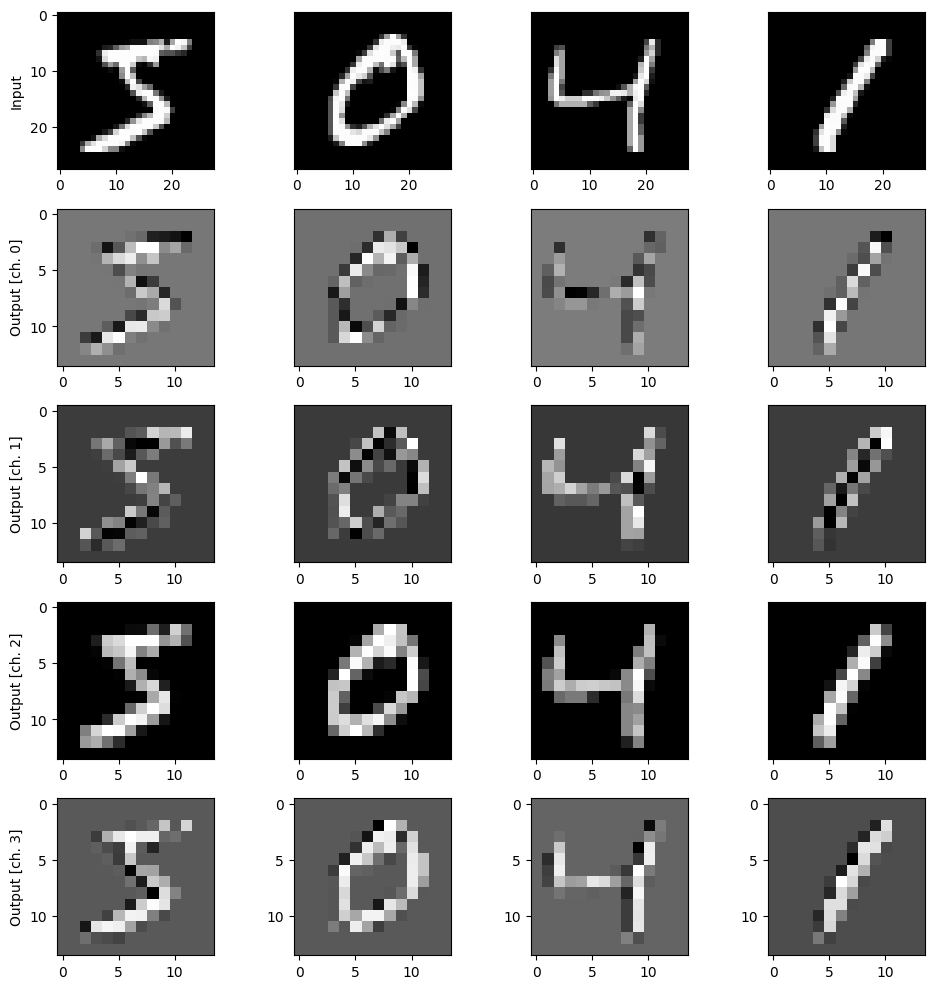

In [5]:
qccnn = Custom_QCCNN(n_qubits, device, n_blocks, n_shots, optimizer, loss, learning_rate, opt_model_path, np_arrays_path)

quantum_train_images, quantum_test_images, params = qccnn.quantum_conv_preprocessing(train_images, test_images)

n_samples = 5
qccnn.plot_quantum_images(train_images, quantum_train_images, n_samples)

5. Upload the quantum_train_images and quantum_test_images if required and create the qccnn object again

In [6]:
upload = False
if upload:
    quantum_train_images= np.load(np_arrays_path + "quantum_train_images.npy")
    quantum_test_images = np.load(np_arrays_path + "quantum_test_images.npy")
    qccnn = Custom_QCCNN(n_qubits, device, n_blocks, n_shots, optimizer, loss, learning_rate, opt_model_path, np_arrays_path)
    qccnn.params = np.load(np_arrays_path + "quantum_random_params.npy")    

6. For random quantum parameters, train the classical convolutional neural network

In [7]:
batch_size = 16
n_epochs = 60
early_stop_crit = False

history = qccnn.train(
                preprocessing=False,
                train_images=quantum_train_images, 
                train_labels=train_labels, 
                validation_images=quantum_test_images, 
                validation_labels=test_labels, 
                batch_size=batch_size, 
                n_epochs=n_epochs,
                early_stop_crit=early_stop_crit
                )

print("Training of the classical convolutional neural network completed.")


Epoch 1/60
19/19 - 4s - 184ms/step - accuracy: 0.1900 - loss: 2.2663 - val_accuracy: 0.2267 - val_loss: 2.2253
Epoch 2/60
19/19 - 0s - 14ms/step - accuracy: 0.3867 - loss: 2.1219 - val_accuracy: 0.4000 - val_loss: 2.1046
Epoch 3/60
19/19 - 0s - 19ms/step - accuracy: 0.5267 - loss: 1.9463 - val_accuracy: 0.5067 - val_loss: 1.9283
Epoch 4/60
19/19 - 0s - 17ms/step - accuracy: 0.5900 - loss: 1.7236 - val_accuracy: 0.5333 - val_loss: 1.7295
Epoch 5/60
19/19 - 0s - 25ms/step - accuracy: 0.6567 - loss: 1.4762 - val_accuracy: 0.5600 - val_loss: 1.5181
Epoch 6/60
19/19 - 0s - 19ms/step - accuracy: 0.7400 - loss: 1.2452 - val_accuracy: 0.6000 - val_loss: 1.3352
Epoch 7/60
19/19 - 0s - 19ms/step - accuracy: 0.7800 - loss: 1.0511 - val_accuracy: 0.6267 - val_loss: 1.1958
Epoch 8/60
19/19 - 0s - 17ms/step - accuracy: 0.8067 - loss: 0.9001 - val_accuracy: 0.6400 - val_loss: 1.0954
Epoch 9/60
19/19 - 0s - 16ms/step - accuracy: 0.8067 - loss: 0.7887 - val_accuracy: 0.6533 - val_loss: 1.0244
Epoch 10/

7. We now train a classical CNN without any quantumness

In [8]:
ccnn = Custom_QCCNN(n_qubits, device, n_blocks, n_shots, optimizer, loss, learning_rate)
start = time()
c_history = ccnn.classical_model().fit(
                train_images,
                train_labels,
                validation_data=(test_images, test_labels),
                batch_size=batch_size,
                epochs=n_epochs,
                verbose=2
                )
end = time()
classical_training_time = end - start

print(f"Training of the classical convolutional neural network completed in {classical_training_time} s.")

Epoch 1/60
19/19 - 4s - 196ms/step - accuracy: 0.3433 - loss: 2.1137 - val_accuracy: 0.5067 - val_loss: 1.8797
Epoch 2/60
19/19 - 0s - 19ms/step - accuracy: 0.7500 - loss: 1.3818 - val_accuracy: 0.6533 - val_loss: 1.2477
Epoch 3/60
19/19 - 0s - 17ms/step - accuracy: 0.8467 - loss: 0.7518 - val_accuracy: 0.7600 - val_loss: 0.8805
Epoch 4/60
19/19 - 0s - 20ms/step - accuracy: 0.8867 - loss: 0.4724 - val_accuracy: 0.7733 - val_loss: 0.7564
Epoch 5/60
19/19 - 0s - 19ms/step - accuracy: 0.9267 - loss: 0.3326 - val_accuracy: 0.8000 - val_loss: 0.6777
Epoch 6/60
19/19 - 0s - 18ms/step - accuracy: 0.9500 - loss: 0.2329 - val_accuracy: 0.8133 - val_loss: 0.6432
Epoch 7/60
19/19 - 0s - 17ms/step - accuracy: 0.9667 - loss: 0.1698 - val_accuracy: 0.8400 - val_loss: 0.6158
Epoch 8/60
19/19 - 0s - 17ms/step - accuracy: 0.9867 - loss: 0.1231 - val_accuracy: 0.8400 - val_loss: 0.6081
Epoch 9/60
19/19 - 0s - 23ms/step - accuracy: 0.9900 - loss: 0.0920 - val_accuracy: 0.8133 - val_loss: 0.6093
Epoch 10/

7. Plot validation loss and validation accuracy

Figure saved at C:/Users/a943763/OneDrive - ATOS/Documentos/Python/QML/figures_qccnn/qccnn_loss_parametersD.png


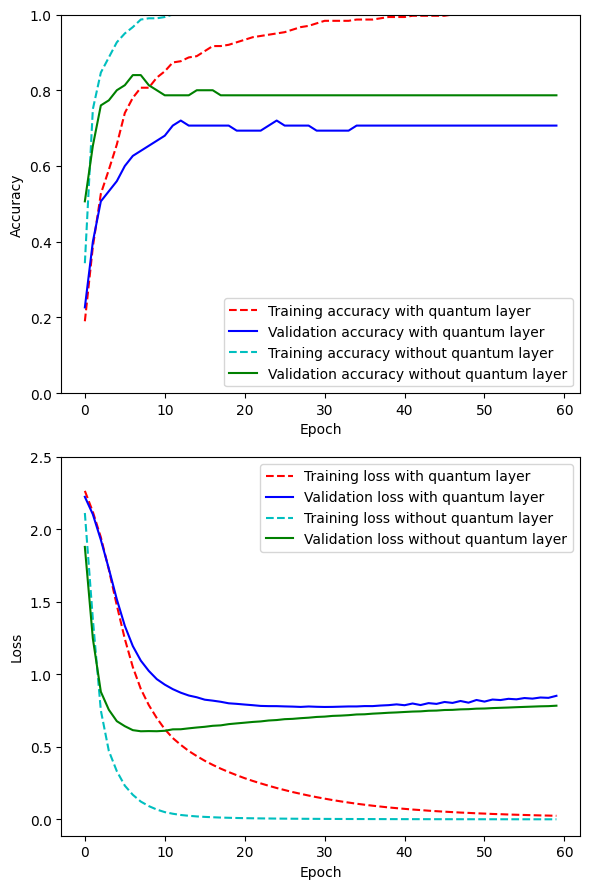

: 

In [ ]:
fig_path = 'C:/Users/a943763/OneDrive - ATOS/Documentos/Python/QML/figures_qccnn/'
loss_fig_name = 'qccnn_loss_parametersD.png'
qccnn.plot_loss(c_history=c_history, fig_path=fig_path, fig_name=loss_fig_name)

8. Train the quantum convolutional network

In [ ]:
method = 'cobyla'
max_iter = 30
n_train_images_q_opt = 100

train_images_q_opt= train_images[:n_train_images_q_opt,:,:,:]
train_labels_q_opt = train_labels[:n_train_images_q_opt]

start = time()
result, train_accuracies, train_losses = qccnn.optimize_quantum_params(train_images_q_opt, train_labels_q_opt, method, max_iter)
end = time()
quantum_training_time = end - start

print(f"Quantum training result: {result}")
print(f"\nTraining accuracies: {train_accuracies}")
print(f"\nTraining losses: {train_losses}")
print(f"\nQuantum training time: {quantum_training_time:.2f} seconds")

9. Plot the training accuracy and loss of the quantum ansatz optimization

Figure saved at C:/Users/a943763/OneDrive - ATOS/Documentos/Python/QML/figures_qccnn/qccnn_quantum_loss.png


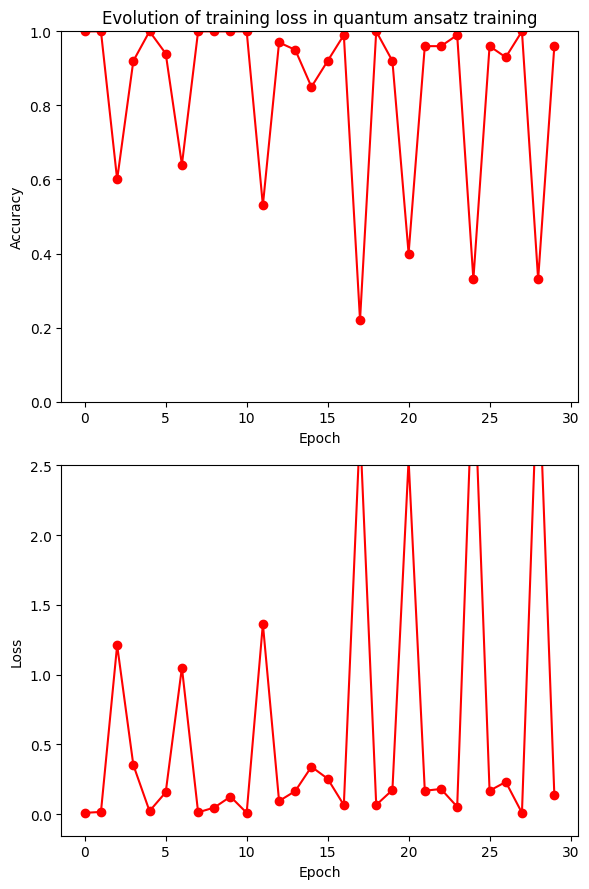

In [ ]:
q_loss_fig_name = 'qccnn_quantum_loss_parametersD.png'
qccnn.plot_q_train_loss(train_accuracies=train_accuracies, train_losses=train_losses, fig_path=fig_path)

10. Evaluate the whole model with quantum and classical optimized parameters for test images to analyse performance

In [ ]:
n_test_images = 50
test_images = test_images[:n_test_images,:,:,:]
test_labels = test_labels[:n_test_images]

test_loss, test_accuracy = qccnn.predict(
                                preprocessing=True,
                                test_images=test_images,
                                test_labels=test_labels
                                )

print(f"Test loss: {test_loss}, Test accuracy: {test_accuracy}")

Test loss: 0.5377779603004456, Test accuracy: 0.8600000143051147


### References

[1] Géron, A. (2022). *Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow*. O'Reilly Media, Inc.

[2] Ravjot Singh, “Decoding CNNs: A Beginner’s Guide to Convolutional Neural Networks and their Applications,” Medium, Dec. 30, 2024. [Online]. Available: https://ravjot03.medium.com/decoding-cnns-a-beginners-guide-to-convolutional-neural-networks-and-their-applications-1a8806cbf536

[3] I. Cong, S. Choi, and M. D. Lukin, “Quantum convolutional neural networks,” *Nature Physics*, vol. 15, no. 12, pp. 1273–1278, 2019.

[4] T. Hur, L. Kim, and D. K. Park, “Quantum convolutional neural network for classical data classification,” *Quantum Machine Intelligence*, vol. 4, no. 1, p. 3, 2022.

[5] M. Henderson, S. Shakya, S. Pradhan, and T. Cook, “Quanvolutional neural networks: powering image recognition with quantum circuits,” *Quantum Machine Intelligence*, vol. 2, no. 1, p. 2, 2020.

[6] N. Matondo-Mvula and K. Elleithy, “Breast cancer detection with quanvolutional neural networks,” *Entropy*, vol. 26, no. 8, p. 630, 2024.




